# Project Task: 
Assessing the Impact of Tea Advertising on Television on Tea Sales

In [315]:
import pandas as pd
import re
from datetime import datetime
import seaborn as sns
import scipy
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [260]:
df = pd.read_csv("tea_demand.csv")
df.head()

,brand_id\tdate\treceipts_count
0,5152\t2016-07-01\t98
1,178\t2016-07-01\t234
2,29\t2016-07-01\t622
3,5152\t2016-07-02\t87
4,178\t2016-07-02\t185


In [261]:
df["date"] = df['brand_id\tdate\treceipts_count'].apply(lambda x: datetime.strptime(x.split("\t")[1], '%Y-%m-%d'))
df["receipts_count"] = df['brand_id\tdate\treceipts_count'].apply(lambda x: int(x.split("\t")[2]))
df["brand_id"] = df['brand_id\tdate\treceipts_count'].apply(lambda x: int(x.split("\t")[0]))
df.drop(['brand_id\tdate\treceipts_count'], inplace = True, axis = 1)
df.head()

,date,receipts_count,brand_id
0,2016-07-01,98,5152
1,2016-07-01,234,178
2,2016-07-01,622,29
3,2016-07-02,87,5152
4,2016-07-02,185,178


In [262]:
# Group sales by date and vendor
df = df.groupby(['date']).sum()
df.drop(['brand_id'], inplace = True, axis = 1)
df.head()

,receipts_count
date,
2016-07-01,954
2016-07-02,852
2016-07-03,982
2016-07-04,887
2016-07-05,1002


Look at the time series of sales

<AxesSubplot:xlabel='date'>

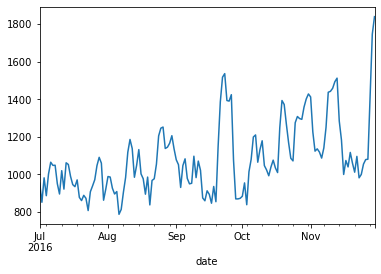

In [263]:
df.receipts_count.plot()

The graph shows spikes in sales on some days. Let's check if these jumps are caused by advertising produced in the TV program "What? Where? When?"

### Parsing

Since there is not much data in tea_demand.csv, it does not make sense to parse all the release dates of the program since 1975. In my opinion, it would be enough to manually google the dates for a certain period.

Define the boundaries of the time interval

In [35]:
df.date.min()

Timestamp('2016-07-01 00:00:00')

In [36]:
df.date.max()

Timestamp('2016-11-30 00:00:00')

So, we are interested in data from July 1, 2016 to November 30, 2016. According to google, there were only 7 such broadcasts during this period, parsing with python in this case is absolutely inadequate.

Show release dates:

25 - 09 - 2016	

2 - 10 - 2016	

9 - 10 - 2016	

16 - 10 - 2016	

23 - 10 - 2016	

21 - 11 - 2016	

28 - 11 - 2016

In [194]:
show_these_dates = ['2016-09-25', '2016-10-02', '2016-10-09', '2016-10-16', 
                    '2016-10-23', '2016-11-21', '2016-11-28']
#df[df['date'] in [show_these_dates]]

### Let's build a model that predicts the value of the time series of sales.

Try a moving average model. Let's try to take 7 days (a week) window. Then we compare the result with the last 7 days, which were not used in the calculation of the moving average.

In [284]:
df[moving_average_days:].index

DatetimeIndex(['2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11',
               '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15',
               '2016-07-16', '2016-07-17',
               ...
               '2016-11-21', '2016-11-22', '2016-11-23', '2016-11-24',
               '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
               '2016-11-29', '2016-11-30'],
              dtype='datetime64[ns]', name='date', length=146, freq=None)

(7,) (7,)
mean_squared_error 139483.97667638486
mean_absolute_error 257.3877551020408


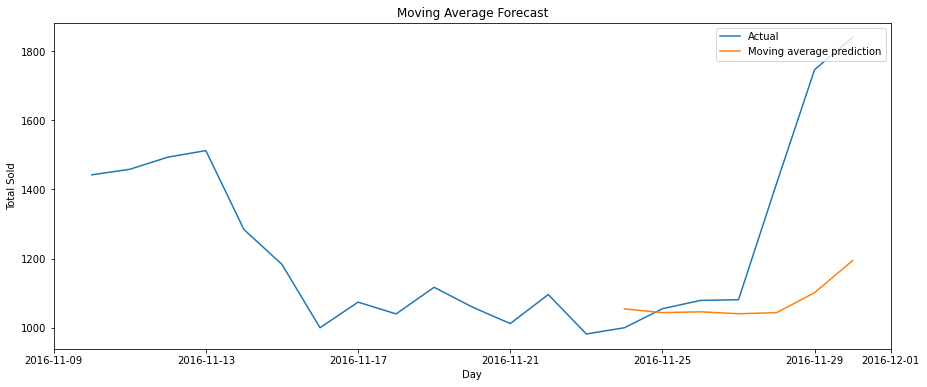

In [288]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 7

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(df.receipts_count, moving_average_days )
moving_avg = pd.Series(moving_avg, index = df[moving_average_days:].index)

print(moving_avg[-moving_average_days:].shape, df.receipts_count[-moving_average_days:].shape)

print("mean_squared_error",mean_squared_error(df.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("mean_absolute_error",mean_absolute_error(df.values[-moving_average_days:], moving_avg[-moving_average_days:]))

plt.figure(figsize=(15,6))

plt.plot(df[- shown_train_size:], label="Actual")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Total Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

The forecast is not perfect, however, this model predicts the trend quite ok, since the silhouettes of the charts are similar.

In [305]:
anomaly_df = pd.DataFrame()
anomaly_df['date'] = df[moving_average_days:].index
anomaly_df['value'] = df.receipts_count[moving_average_days:].values
anomaly_df['predicted'] = moving_avg.values

In [306]:
anomaly_df

,date,value,predicted
0,2016-07-08,1049,970.000000
1,2016-07-09,951,983.571429
2,2016-07-10,896,997.714286
3,2016-07-11,1020,985.428571
4,2016-07-12,922,1004.428571
...,...,...,...
141,2016-11-26,1079,1046.000000
142,2016-11-27,1081,1040.571429
143,2016-11-28,1417,1043.571429
144,2016-11-29,1746,1101.428571


### Anomaly detection using BoxPlot and IQR

<AxesSubplot:xlabel='receipts_count'>

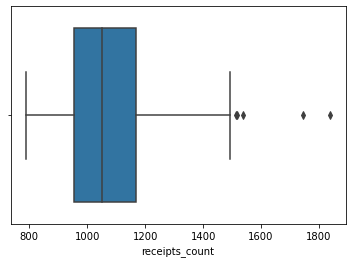

In [309]:
# Let's build a BoxPlot and see if there are outliers
sns.boxplot(df.receipts_count)

We see that the number of checks > 1500 can potentially be an outlier

Let's count the number of anomalies

In [310]:
Q1 = df.receipts_count.quantile(0.25)
Q3 = df.receipts_count.quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['receipts_count'] > (Q3+1.5*IQR)) 
                        | (df['receipts_count'] < (Q1-1.5*IQR))].reset_index()

print('Number of anomalies: {:.0f}'.format(len(outliers)))

Количество аномальных точек: 5


### Anomaly detection using DBSCAN

In [312]:
dbscan = DBSCAN(eps=1)

In [313]:
anomaly_df['is_anomaly_dbscan'] = dbscan.fit_predict(anomaly_df['value'].values.reshape(-1, 1))
anomaly_df.head()

,date,value,predicted,is_anomaly_dbscan
0,2016-07-08,1049,970.000000,0
1,2016-07-09,951,983.571429,-1
2,2016-07-10,896,997.714286,-1
3,2016-07-11,1020,985.428571,-1
4,2016-07-12,922,1004.428571,-1


In [314]:
# Detected anomalies
anomaly_df[anomaly_df.is_anomaly_dbscan < 0]

,date,value,predicted,is_anomaly_dbscan
1,2016-07-09,951,983.571429,-1
2,2016-07-10,896,997.714286,-1
3,2016-07-11,1020,985.428571,-1
4,2016-07-12,922,1004.428571,-1
5,2016-07-13,1062,993.000000,-1
...,...,...,...,...
141,2016-11-26,1079,1046.000000,-1
142,2016-11-27,1081,1040.571429,-1
143,2016-11-28,1417,1043.571429,-1
144,2016-11-29,1746,1101.428571,-1


DBscan found much more anomalies - 141

### Anomaly detection using agglomerative clustering

In [316]:
agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=1)

In [317]:
anomaly_df['is_anomaly_prediction_agglom'] = agglom.fit_predict(anomaly_df['value'].values.reshape(-1, 1))
anomaly_df.head()

,date,value,predicted,is_anomaly_dbscan,is_anomaly_prediction_agglom
0,2016-07-08,1049,970.000000,0,129
1,2016-07-09,951,983.571429,-1,128
2,2016-07-10,896,997.714286,-1,25
3,2016-07-11,1020,985.428571,-1,106
4,2016-07-12,922,1004.428571,-1,12


In [318]:
valcount = anomaly_df['is_anomaly_prediction_agglom'].value_counts()
valcount = set(valcount[valcount == 1].index)
anomaly_df[anomaly_df.is_anomaly_prediction_agglom.isin(valcount)]

,date,value,predicted,is_anomaly_dbscan,is_anomaly_prediction_agglom
0,2016-07-08,1049,970.000000,0,129
1,2016-07-09,951,983.571429,-1,128
3,2016-07-11,1020,985.428571,-1,106
5,2016-07-13,1062,993.000000,-1,101
6,2016-07-14,1053,992.571429,-1,127
...,...,...,...,...,...
141,2016-11-26,1079,1046.000000,-1,13
142,2016-11-27,1081,1040.571429,-1,8
143,2016-11-28,1417,1043.571429,-1,9
144,2016-11-29,1746,1101.428571,-1,3


Agglomerative clustering detected 115 anomalies

### Anomaly detection using ML

In [319]:
# Several Helper Methods

def getDistanceByPoint(data, model):
    # Calculation of distances from points to cluster centers
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)    
    return distance

def getTransitionMatrix (df):
    # Calculation of transition probabilities to the next state (stupid predictor)
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    # Search for anomalies in the sequence of signals based on the Markov transition matrix
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [330]:
df_ml = pd.DataFrame()
df_ml['date'] = df.index
df_ml['value'] = df.receipts_count.values

In [331]:
# Look at the data
df_ml.head()

,date,value
0,2016-07-01,954
1,2016-07-02,852
2,2016-07-03,982
3,2016-07-04,887
4,2016-07-05,1002


<AxesSubplot:xlabel='date'>

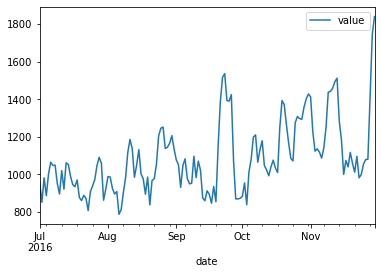

In [332]:
df_ml.plot(x='date', y='value')

In [333]:
# Start generating features

df_ml['DayOfTheWeek'] = df_ml['date'].dt.dayofweek
df_ml['WeekDay'] = (df_ml['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01

In [335]:
# Let's add a sign if the TV program was broadcast on this day
www_dates = [pd.to_datetime(date) for date in show_these_dates]
df_ml['WWWDay'] = df_ml['date'].apply(lambda x: 1 if x in www_dates else 0)

In [348]:
df_ml['timestamp'] = df_ml['date'].apply(lambda x: x.timestamp())
df_ml['time_epoch'] = (df_ml['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [349]:
df_ml

,date,value,DayOfTheWeek,WeekDay,WWWDay,cluster,principal_feature1,principal_feature2,timestamp,time_epoch
0,2016-07-01,954,4,1,0,0,-0.040521,-0.654871,1.467331e+09,0
1,2016-07-02,852,5,0,0,3,1.359431,-1.143520,1.467418e+09,0
2,2016-07-03,982,6,0,0,3,1.530412,-0.651078,1.467504e+09,0
3,2016-07-04,887,0,1,0,0,-0.975756,-0.842158,1.467590e+09,0
4,2016-07-05,1002,1,1,0,0,-0.796454,-0.408738,1.467677e+09,0
...,...,...,...,...,...,...,...,...,...,...
148,2016-11-26,1079,5,0,0,3,1.233498,-0.250312,1.480118e+09,0
149,2016-11-27,1081,6,0,0,3,1.475490,-0.261529,1.480205e+09,0
150,2016-11-28,1417,0,1,1,1,-0.378360,4.161940,1.480291e+09,0
151,2016-11-29,1746,1,1,0,2,-1.209203,2.518782,1.480378e+09,0


### Clustering models

In [337]:
data = df_ml[['value', 'DayOfTheWeek', 'WeekDay', 'WWWDay']]

# Normalize data
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Reduce the number of components
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

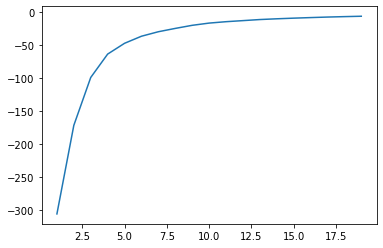

In [338]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [339]:
df_ml['cluster'] = kmeans[3].predict(data)
df_ml['principal_feature1'] = data[0]
df_ml['principal_feature2'] = data[1]
df_ml['cluster'].value_counts()

0    72
2    35
3    34
1    12
Name: cluster, dtype: int64

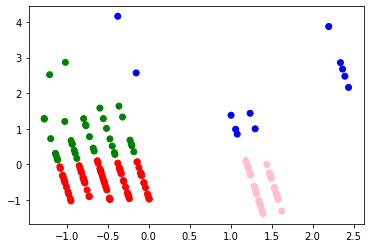

In [340]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df_ml['principal_feature1'], df_ml['principal_feature2'], c=df_ml["cluster"].apply(lambda x: colors[x]))
plt.show()

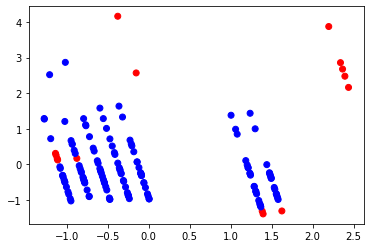

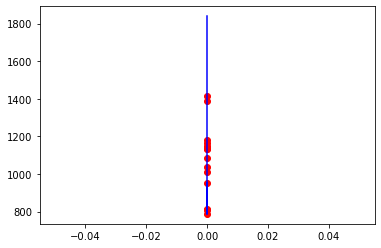

In [350]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# A point is an anomaly if the distance to the cluster center is greater than the threshold
df_ml['anomaly21'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_ml['principal_feature1'], df_ml['principal_feature2'], c=df_ml["anomaly21"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots()

a = df_ml.loc[df_ml['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df_ml['time_epoch'], df_ml['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

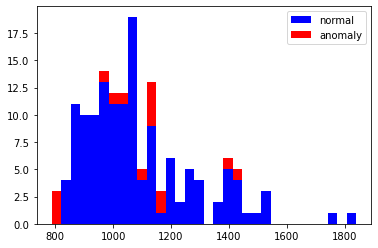

In [351]:
# Look at the distribution of anomalous and real values
a = df_ml.loc[df_ml['anomaly21'] == 0, 'value']
b = df_ml.loc[df_ml['anomaly21'] == 1, 'value']
fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Conclusion:

In conclusion, the analysis of the sales data reveals the presence of anomalies; however, no conclusive evidence was found linking these anomalies to the television advertising. It is important to note that further investigation and additional data are necessary to establish a more comprehensive understanding of the relationship between advertising and sales. Further research is recommended and acquiring a larger dataset to enhance the accuracy and validity of the findings.